In [260]:
## PART 3 - SEAM CARVING - SINTESIS D'IMATGES.
%matplotlib inline

In [261]:
# carreguem totes les llibreries necesaries per a la practica
from skimage import data, draw, color, data, restoration, filters,transform, util
from scipy import misc, fftpack, signal
from scipy.misc import imresize
from scipy import ndimage as nd
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw, ImageEnhance
import matplotlib.animation as animation
import scipy

In [262]:
#normalitzacio d'imatge
def normalitzar(imatge):
    return np.real((imatge - np.min(imatge)) * 256 / (np.max(imatge) - np.min(imatge)))

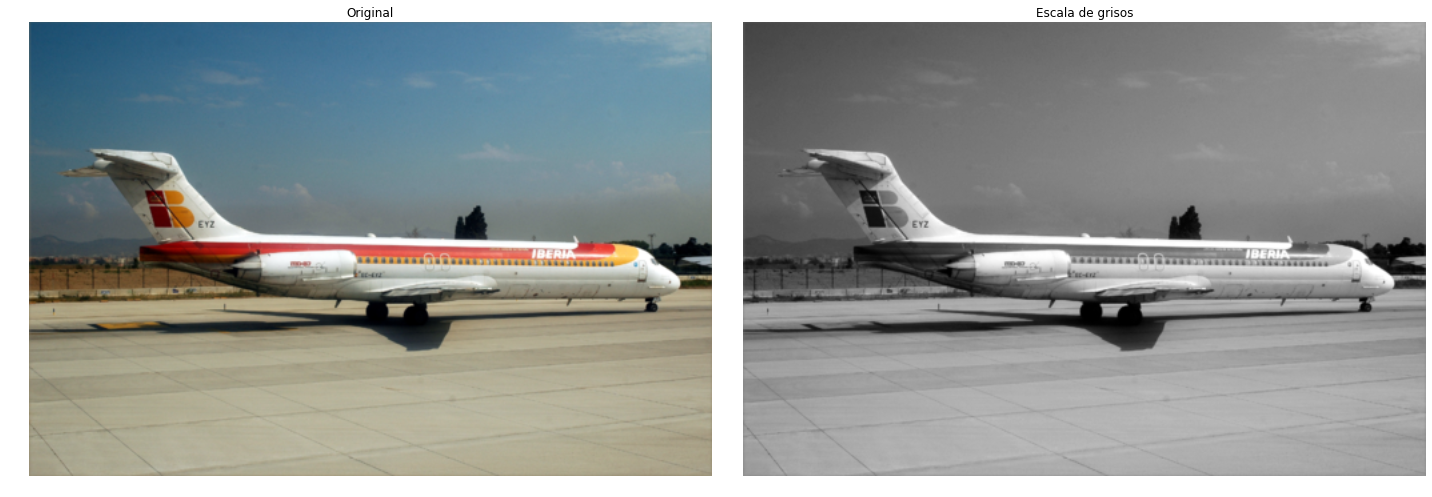

In [263]:
RGB = plt.imread('iberia.jpg')
scale_factor = 2
RGB = imresize(RGB, ( RGB.shape[0]/scale_factor, RGB.shape[1]/scale_factor,3),interp='bilinear').astype('float')
img = color.rgb2gray(RGB)

# Visualitzem la imatge original i la imatge en escala de grisos
fig = plt.figure(1) 
plt.subplot(1,2,1)
plt.imshow(RGB.astype('uint8'))
plt.title('Original')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(norm(img), cmap="gray")
plt.title('Escala de grisos')
plt.axis('off')
plt.gcf().set_size_inches((20,20))
fig.tight_layout()
plt.show()

In [264]:
def gradient(img):
    img = color.rgb2gray(img)
    gx, gy = np.gradient(img)
    grad = np.sqrt(gx*gx + gy*gy)
    return grad

#Calcul matriu d'energia que acomulada te cada zona
def energia(imatge):
    height,width = imatge.shape
    energia=np.zeros(imatge.shape)
    #asignem la primera linea igual que la imatge que tenim
    energia[0]=imatge[0]   
    for x in range(1,height):
        for y in range(0,width):
            if y == 0:#inici de la imatge
                min_val = min( energia[x-1, y], energia[x-1, y+1] )
            elif y < width - 2:#abans del final de la imatge
                min_val = min( energia[x-1, y], energia[x-1, y+1] )
                min_val = min( min_val, energia[x-1, y-1] )
            else:#final de la imatge
                min_val = min( energia[x-1, y], energia[x-1, y-1] )
            energia[x,y] = imatge[x,y] + min_val#valor acomulat d'energia
    return energia

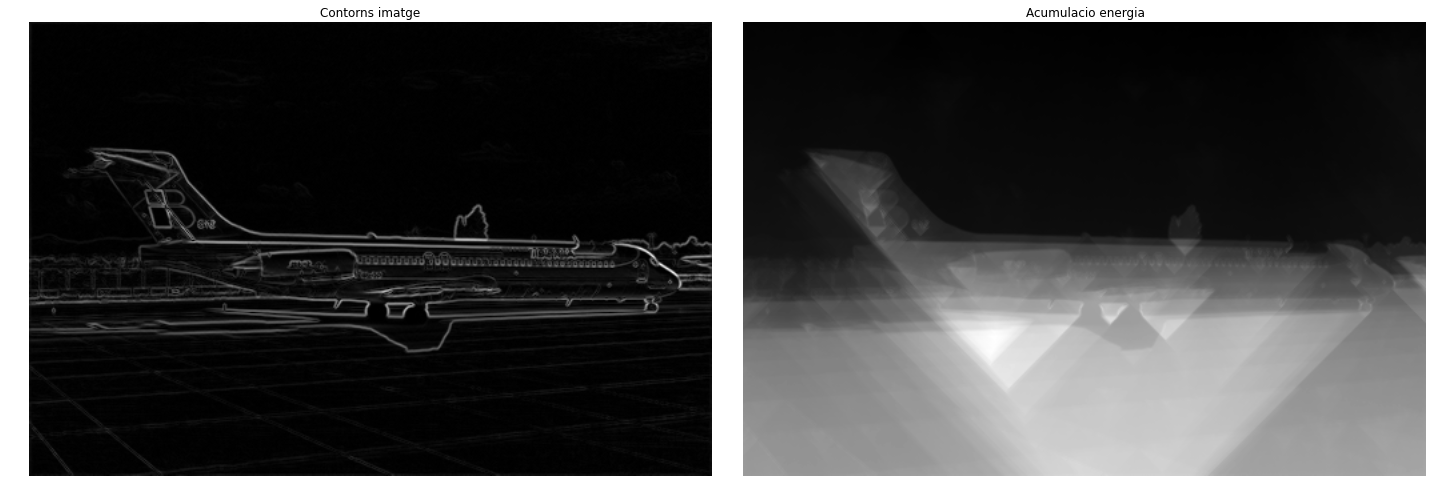

In [265]:
grad = gradient(img)
energy = energia(grad)

#Visualization
fig = plt.figure(2) 
plt.subplot(1,2,1)
plt.imshow(norm(grad), cmap="gray")
plt.title('Contorns imatge')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(norm(energy), cmap="gray" )
plt.title('Acumulacio energia')
plt.axis('off')
plt.gcf().set_size_inches((20,20))
fig.tight_layout()
plt.show()


In [269]:
# El calcul del tall vertical hem de buscar el cami amb cost minim. BACKTRACKING
# Aquest tall pot ser vertical o horitzontal, es un camí de pixels connectats. En el nostre cas l'apliquem vertical
# La función de importancia / energía valora un píxel mediante la medición de su contraste con sus píxeles vecinos.
# Des de la imatge en escala de grisos retornarem el tall vertical mes baix com a llista de pixels

def tall_vertical(im, it):
    # Anem fins al -1 perque aixi es quedara en el 0, que tambe el necessitem.
    width, height = im.shape
    cost = energia(gradient(im))
    
    paths = []
    min_val =np.max(cost)+1
    path = []

    # mirem el minim cami que no hem visitat
    for y in range(height):
        if cost[width-1,y] < min_val:
            min_val = cost[width-1,y]
            min_ptr = y

    visited.append(min_ptr)
    pos = (width-1, min_ptr)
    path.append(pos)

    while pos[0] != 0:
        val = cost[pos] - grad[pos]
        x,y = pos
        if y == 0:
            if val == cost[x-1,y+1]:
                pos = (x-1,y+1) 
            else:
                pos = (x-1,y)
        elif y <= height - 2:
            if val == cost[x-1,y+1]:
                pos = (x-1,y+1) 
            elif val == cost[x-1,y]:
                pos = (x-1,y)
            else:
                pos = (x-1,y-1)
        else:
            if val == cost[x-1,y]:
                pos = (x-1,y)
            else:
                pos = (x-1,y-1) 

        path.append(pos)

    print "iteration",i,"--",path[0][1]
    paths.append(path)

def mark_seam (mat, path, mark_as='red'):
    #Dono maxim valor al canal corresponent al color escollit a tots els pixels del path que ens marca el cami a borrar
    for i in path:
        if mark_as == 'red':
            mat[i] = (255,0,0)
        elif mark_as == 'green':
            mat[i] = (0,255,0)
        elif mark_as == 'blue':
            mat[i] = (0,0,255)
        elif mark_as == 'white':
            mat[i] = (255,255,255)
        elif mark_as == 'black':
            mat[i] = (0,0,0)
    
    return mat; 

# fem un calcul de la mitja dels valors
def vector_mitja(u, v):
    w = u.astype('uint16')
    for i in range(len(w)):
        w[i] = (w[i] + v[i])/2

    return w.astype('uint8')

# Funcio per afegir el seam vertical
def afegir_seam(img, path):
    height, width = img.shape[:2]
    i = np.zeros((height, width+1, img.shape[2]))
    
    path_set = set(path)
    seen_set = set()
    
    for x in xrange(height):
        for y in xrange(width):
            if (x,y) not in path_set and x not in seen_set:
                i[x,y] = img[x,y]
            elif (x,y) in path_set and x not in seen_set:
                i[x,y] = img[x,y]
                seen_set.add(x)
                if y <= width - 2:
                    i[x,y+1] = vector_mitja(img[x,y], img[x,y+1])
                else:
                    i[x,y+1] = vector_mitja(img[x,y], img[x,y-1])
            else:
                i[x,y+1] = img[x,y]

    return i

In [270]:
def carving(iteracio,rgb):
    result = rgb.copy();
    seams = []

    gray = color.rgb2gray(rgb)
    path = tall_vertical(gray,iteracio)

    for p in path:
        rgb = mark_seam(rgb, p, 'blue')
        seams.append([plt.imshow(rgb.astype('uint8'))])
        result = afegir_seam(result, p)

    return result, seams;

iteration 0 	path @ 56
iteration 1 	path @ 58
iteration 2 	path @ 48
iteration 3 	path @ 59
iteration 4 	path @ 57
iteration 5 	path @ 51
iteration 6 	path @ 52
iteration 7 	path @ 55
iteration 8 	path @ 49
iteration 9 	path @ 54
iteration 10 	path @ 45
iteration 11 	path @ 53
iteration 12 	path @ 60
iteration 13 	path @ 46
iteration 14 	path @ 47
iteration 15 	path @ 42
iteration 16 	path @ 50
iteration 17 	path @ 41
iteration 18 	path @ 40
iteration 19 	path @ 61
iteration 20 	path @ 43
iteration 21 	path @ 44
iteration 22 	path @ 39
iteration 23 	path @ 37
iteration 24 	path @ 34
iteration 25 	path @ 62
iteration 26 	path @ 36
iteration 27 	path @ 38
iteration 28 	path @ 63
iteration 29 	path @ 35
iteration 30 	path @ 64
iteration 31 	path @ 66
iteration 32 	path @ 67
iteration 33 	path @ 65
iteration 34 	path @ 33
iteration 35 	path @ 68
iteration 36 	path @ 104
iteration 37 	path @ 69
iteration 38 	path @ 106
iteration 39 	path @ 105
iteration 40 	path @ 30
iteration 41 	path @ 75

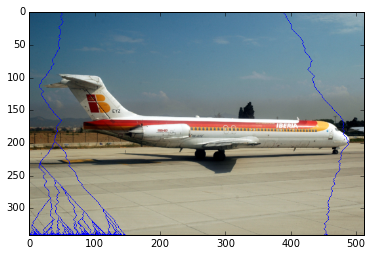

In [271]:
fig = plt.figure(3)
result, seams = seam_enlargement(150, RGB.copy());
print result.shape

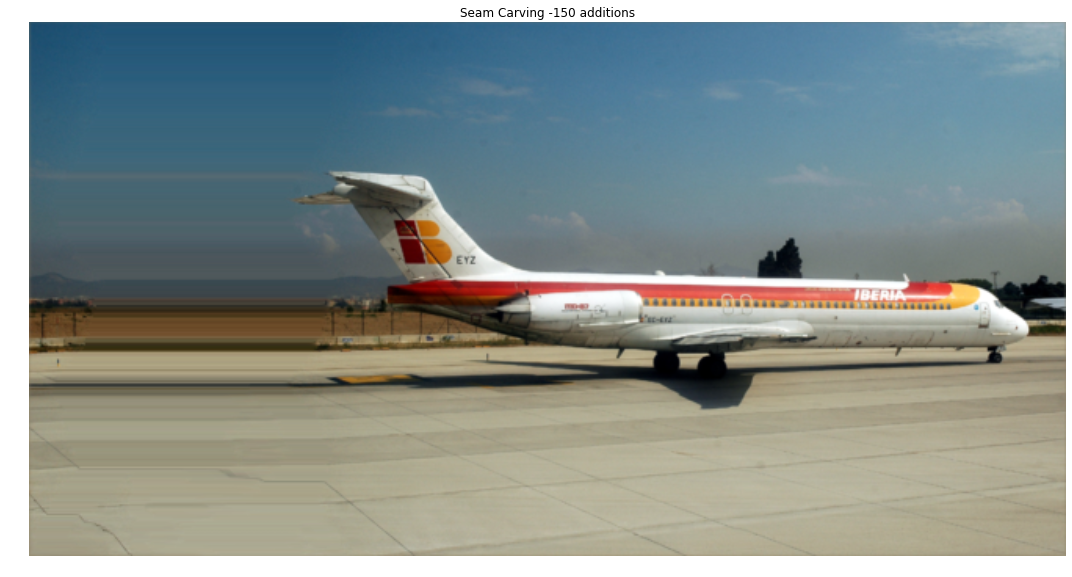

In [273]:
#Visualization
fig = plt.figure(4) 
plt.imshow(result.astype('uint8'))
plt.title('Seam Carving -'+ str(N) + ' additions')
plt.axis('off')
plt.gcf().set_size_inches((15,15))
fig.tight_layout()